<table class="table table-bordered">
    <tr>
        <th style="text-align:center; width:25%"><img src='https://www.np.edu.sg/PublishingImages/Pages/default/odp/ICT.jpg' style="width: 250px; height: 125px; "></th>
        <th style="text-align:center;"><h1>Deep Learning</h1><h2>Assignment 2 - Sentiment Analysis Model (Problem 1)</h2><h3>AY2020/21 Semester</h3></th>
    </tr>
</table>

Objective: Build a sentiment analysis model to predict the emoticon for each text input. 


In [1]:
DATA_DIR = "../data"

In [40]:
# autoformat code on cell run.
%load_ext lab_black
# autoreload imported modules on change
%load_ext autoreload
%autoreload 2

# Import the Required Packages
import os
import gc
import mlflow
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as pl

from git import Repo
from minio import Minio
from zipfile import ZipFile
from textblob import TextBlob
from unidecode import unidecode
from emot import emoji, emoticons
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from gensim.models.fasttext import load_facebook_model, load_facebook_vectors
from gensim.models.wrappers import FastText
from gensim.parsing.preprocessing import remove_stopwords, strip_punctuation, stem_text
from tensorflow.keras.utils import to_categorical
from modeling import (
    dense_classifier,
    rnn_block,
    compile_callbacks,
    build_model,
    train_eval_model,
)

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


Configure access to MLFlow by setting the following environment variables:
- `MLFLOW_TRACKING_URI` - URL to the MLFlow Tracking server.
- `MLFLOW_S3_ENDPOINT_URL` - URL to the MLFlow S3 Backend Store
- `MLFLOW_EXPERIMENT` - Optional. The name of the MLFlow experiment to log to.
- `MINIO_HOST` - End to the Minio S3 Store.
- `AWS_ACCESS_KEY_ID` - MLFlow S3 backend store Avectorsccess Key ID.
- `AWS_SECRET_ACCESS_KEY` - MLFlow S3 backend store secret access key.

`TF_FORCE_GPU_ALLOW_GROWTH` -  Force Tensorflow to allocate GPU memory dynamically
instead of of all at once as a workaround for this
[cuDNN failed to initialize issue](https://github.com/tensorflow/tensorflow/issues/24828).

In [3]:
%env TF_FORCE_GPU_ALLOW_GROWTH=true

env: TF_FORCE_GPU_ALLOW_GROWTH=true


Start MLFlow run with the name of the commit as fthe run name.

In [4]:
mlflow.set_experiment(os.environ.get("MLFLOW_EXPERIMENT", "staging"))

In [5]:
repo = Repo(search_parent_directories=True)
mlflow.start_run(run_name=repo.head.commit.message)

<ActiveRun: >

Setup `minio` client.

In [6]:
minio = Minio(
    endpoint=os.environ["MINIO_HOST"],
    access_key=os.environ["AWS_ACCESS_KEY_ID"],
    secret_key=os.environ["AWS_SECRET_ACCESS_KEY"],
    secure=False,
)

# Step 1 – Data Loading and Processing

### 1.1 Data Loading

In [7]:
# Load the emoji_dictionary
df = pd.read_csv(f"{DATA_DIR}/mapping.csv", delimiter=",")
emoji_dictionary = df.loc[:, "emoticons"].to_dict()
print(emoji_dictionary)
print("A total of: ", len(emoji_dictionary), "Emoji Icons")

{0: '😍', 1: '😂', 2: '📷', 3: '🔥', 4: '❤'}
A total of:  5 Emoji Icons


Since the emojis can't be rendered in some situations such as graph plotting, create a mapping for the labels to emoji nameategorical types for the grouping variables to control the order of plot elements.

In [8]:
emoji_names = {
    0: "heart-eyes",
    1: "crying-laughing",
    2: "camera",
    3: "fire",
    4: "heart",
}

In [9]:
# load the dataset
df = pd.read_csv(f"{DATA_DIR}/dataset.csv", delimiter=",")
texts = df.loc[:, "TEXT"].values
labels = df.loc[:, "Label"].values

In [10]:
# Check the maximum length of texts
max_len = -1
for example in texts:
    if len(example.split()) > max_len:
        max_len = len(example.split())

print("the maximum length of the text inputs is ", max_len)

the maximum length of the text inputs is  34


### 1.2 EDA

View the first 5 rows of data:

In [11]:
df.head()

,TEXT,Label
0,Been friends since 7th grade. Look at us now w...,0
1,This is what it looks like when someone loves ...,1
2,RT @user this white family was invited to a Bl...,1
3,"Westenders @user #LAZzNation @ Weston, Toronto\n",2
4,Maxwell heads home @ Summa Akron City Hospital\n,0


Splice in actual emojis and names to make the data easier to grasp than raw number labels:

In [12]:
df["Emoji"] = df["Label"].map(emoji_dictionary)
df["EmojiName"] = df["Label"].map(emoji_names)
df.head()

,TEXT,Label,Emoji,EmojiName
0,Been friends since 7th grade. Look at us now w...,0,😍,heart-eyes
1,This is what it looks like when someone loves ...,1,😂,crying-laughing
2,RT @user this white family was invited to a Bl...,1,😂,crying-laughing
3,"Westenders @user #LAZzNation @ Weston, Toronto\n",2,📷,camera
4,Maxwell heads home @ Summa Akron City Hospital\n,0,😍,heart-eyes


Visualise the distribution of the data examples for each Emoji to check for class imbalance:


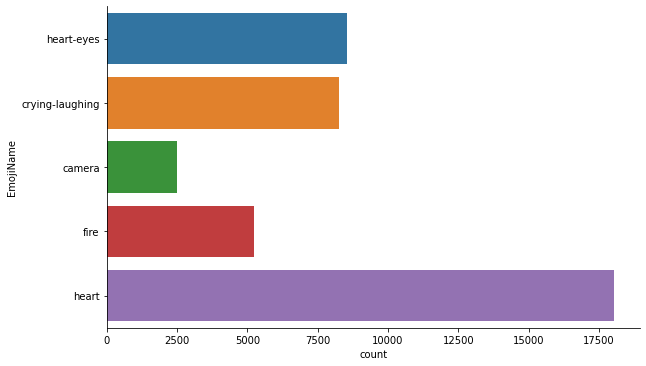

In [13]:
sns.catplot(kind="count", data=df, y="EmojiName", aspect=16 / 9)

In [14]:
df["Emoji"].value_counts()

❤    18043
😍     8537
😂     8247
🔥     5223
📷     2496
Name: Emoji, dtype: int64

Observations:
- The disparty between the number of examples between the different Emojis show a significant class imbalance.
- Metrics such as accuracy will not produce accurate results until the class imbalance issue is resolved. [[1]](https://machinelearningmastery.com/failure-of-accuracy-for-imbalanced-class-distributions/)

Glancing through the data examples, one can make the following observations about the data:
- Although there are no Emojis used in the data, emoticons such as `:)` or `:(` are present in the text data.
- Common contractions ie `w/` to represent `with` are present in the text data.
- Stylised words such as `O B E S S E D` will need to be converted its normal `obsessed` equavilent
- Location words seem highly indicative that the class should be a 📷
- The dataset mentions many locations in the US, as such state contractions such as NY for New York, LA for Los Angles can be safely expanded.

### 1.3 Data Processing


Split the data to train/test subsets reserve 1000 examples for the test set:

In [15]:
n_test = 5000
mlflow.log_param("test_size", n_test)
# Split the X & y into train and test set
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["TEXT"], df["Label"], test_size=n_test
)

**Cleaning text data**: [[2]](https://www.kaggle.com/sudalairajkumar/getting-started-with-text-preprocessing) [[4]](https://www.sciencedirect.com/science/article/abs/pii/S0957417418303683)
- `lower_case` - Convert all text tokens to lower case so that `Happy` and `happy` will appear the same to the model.
- `replace_emot` - Replace emoticons such `:)` with their textual equvilent `happy`.
- `remove_punc` - Remove punctuations such that `yes!` and `yes` would appear the same to model. Also removes trailing newlines.
- `replace_unicode` - Replace unicode symbols such as `α` with `a`.
- `replace_abbv` - Replace common abbreviations and contractions by by look up their full forms. Uses [slang.txt](https://raw.githubusercontent.com/Deffro/text-preprocessing-techniques/master/slang.txt)
- `stopwords` - Removal of stopwords: meaningless words such as `the`, `a`, that are likely irrelevant to prediction.
- `stemming` - Remove inflections from words (ie jump**ing**, jump**ed**, jump**s**,) by steming them. Mutually exclusive with `lemmatization`. Implies `lower_case`.
- `lemmatization` - Remove inflections from words by looking up the word's lemma. Mutually exclusive with `stemming`.
- TODO: remove numbers

In [16]:
def replace(text, mapping):
    """Replace words in the text that match the key in the mapping dict with its value"""
    for word in TextBlob(text).words:
        word = str(word)
        if word in mapping:
            text = text.replace(word, mapping[word])
    return text

Download corpora for replacing abbreviations

In [17]:
!wget https://raw.githubusercontent.com/Deffro/text-preprocessing-techniques/master/slang.txt -O slang.txt

--2021-02-03 01:52:15--  https://raw.githubusercontent.com/Deffro/text-preprocessing-techniques/master/slang.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.8.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.8.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5181 (5.1K) [text/plain]
Saving to: ‘slang.txt’

slang.txt           100%[===================>]   5.06K  --.-KB/s    in 0s      

2021-02-03 01:52:15 (106 MB/s) - ‘slang.txt’ saved [5181/5181]



In [18]:
!wget https://gist.githubusercontent.com/rugbyprof/76575b470b6772ce8fa0c49e23931d97/raw/eb731ce40f9c7c032f4db42e96889a3adbe54f8e/states.py -O states.py

--2021-02-03 01:52:15--  https://gist.githubusercontent.com/rugbyprof/76575b470b6772ce8fa0c49e23931d97/raw/eb731ce40f9c7c032f4db42e96889a3adbe54f8e/states.py
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 151.101.8.133
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|151.101.8.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1091 (1.1K) [text/plain]
Saving to: ‘states.py’

states.py           100%[===================>]   1.07K  --.-KB/s    in 0s      

2021-02-03 01:52:16 (119 MB/s) - ‘states.py’ saved [1091/1091]



In [19]:
clean_params = {
    "lower_case": True,
    "replace_emot": True,
    "remove_punc": True,
    "replace_unicode": True,
    "replace_abbv": True,
    "stopwords": True,
    "stemming": False,
    "lemmatization": True,
}
mlflow.log_params(clean_params)

In [20]:
from states import states as states_map


def clean_texts(texts, clean_params):
    """Cleans the given texts applying clean techniques specified in clean_params
    Returns:
        The given texts with clean techniques applied
    """
    # check mutually exclusive parameters
    assert not (clean_params["stemming"] and clean_params["lemmatization"])

    # remove trailing newlines
    texts = np.asarray([t.rstrip() for t in texts])

    # apply cleaning techniques on copy of dataframe
    if clean_params["lower_case"]:
        texts = np.asarray([t.lower() for t in texts])

    if clean_params["replace_emot"]:

        def replace_emot(text):
            # replace emoticons with meaning if present
            results = emoticons(text)
            if results["flag"]:
                for location, meaning in zip(results["location"], results["mean"]):
                    start, end = location
                    # fix "andry" spelling mistake
                    # https://github.com/NeelShah18/emot/pull/19/files
                    meaning = meaning.replace("andry", "angry")
                    text = f"{text[:start]} {meaning} {text[end+1:]}"
            return text

        texts = np.asarray([replace_emot(t) for t in texts])

    if clean_params["remove_punc"]:
        # … not recognized as puncuation, so remove it manually
        texts = np.asarray([strip_punctuation(t.replace("…", "")) for t in texts])

    if clean_params["replace_unicode"]:
        texts = np.asarray([unidecode(t) for t in texts])

    if clean_params["replace_abbv"]:
        # use utf-sig to fix escape characters
        with open("slang.txt", "r", encoding="utf-8-sig") as f:
            lines = f.readlines()
        abbv_pairs = [tuple(line.split(maxsplit=1)) for line in lines]
        # remove trailing newlines
        abbv_map = {
            # \xa0 - for some reason latin spaces are present, replace with normal spaces.
            abbv: full.rstrip().replace("\xa0", "")
            for abbv, full in abbv_pairs
        }
        # additional abbreviation entries
        abbv_map.update(
            {
                "em": "them",
                "v": "very",
            }
        )
        # expand  US state abbreviations
        abbv_map.update(
            {code.lower(): name.lower() for code, name in states_map.items()}
        )
        texts = np.asarray([replace(t, abbv_map) for t in texts])

    if clean_params["stopwords"]:
        texts = np.asarray([remove_stopwords(t) for t in texts])
    if clean_params["stemming"]:
        texts = np.asarray([stem_text(t) for t in texts])
    if clean_params["lemmatization"]:

        def lemmatize(text):
            lemma_map = {str(w): w.lemmatize() for w in TextBlob(text).words}
            return replace(text, lemma_map)

        texts = np.asarray([lemmatize(t) for t in texts])

    return texts

In [21]:
%%time
clean_train_texts = clean_texts(train_texts, clean_params)
clean_test_texts = clean_texts(test_texts, clean_params)

CPU times: user 23.5 s, sys: 117 ms, total: 23.6 s
Wall time: 23.6 s


In [22]:
!rm slang.txt states.py

TODO: Inspect the clean text:

**Converting text into vectors**:
- `count` - Use the word count to vectorize text. Uses SVD to condense sparse vectors generated. [[5]](https://stackoverflow.com/a/34726420)
- `tfidf` - Use tf-idf to vectorize text. Uses SVD to condense sparse vectors generated. [[5]](https://stackoverflow.com/a/34726420)
- `fasttext` - Use pretrained english fasttext model to vectorize text. [[6]](https://github.com/facebookresearch/fastText/blob/master/docs/pretrained-vectors.md)

> Out of an interest for time, `word2vec` is not included as`word2vec` vectors are significantly worst as compared to `fasttext` [[3]](https://github.com/RaRe-Technologies/gensim/blob/ba1ce894a5192fc493a865c535202695bb3c0424/docs/notebooks/Word2Vec_FastText_Comparison.ipynb)

Download and load pretrained fastext vectors pretrained on common crawl dataset

In [23]:
%%time
# pull pretrained vectors from MINIO cache
minio.fget_object(
    bucket_name="cache",
    object_name="pretrained/fasttext/cc.en.bin",
    file_path="cc.en.bin",
)

CPU times: user 986 ms, sys: 3.13 s, total: 4.12 s
Wall time: 6.12 s


In [24]:
%%time 
fasttext_vecs = load_facebook_vectors("cc.en.bin")

CPU times: user 53.7 s, sys: 13.6 s, total: 1min 7s
Wall time: 1min 8s


In [25]:
# compute max no. of words per data example
max_n_words = max(
    [len(t.split()) for t in np.concatenate((clean_train_texts, clean_test_texts))]
)
vectorize_params = {
    "vectorize_method": "fasttext",
    "vector_shape": (max_n_words, 300),
}
mlflow.log_params(vectorize_params)

In [26]:
def vectorize_texts(texts, corpus_texts, method, vector_shape):
    """
    Vectorize the given texts into 2D feature matrix using the given method.
    Args:
        texts: Iterable collection of texts to vectorize.
        corpus_texts: Vectorization methods are allowed to fit on this corpus.
        method: Name of the method to use for vectorization
        vector_shape: Shape of the 2D feature matrix generated for each data example
            in the form (n_words, n_features)
    Returns vector representation of the given texts.
    """

    if method in ["count", "tfidf"]:
        if method == "count":
            count = CountVectorizer()
            count.fit(corpus_texts)
            sparse_vecs = count.transform(texts)
            # TODO: expand dims
        elif method == "tfidf":
            tfidf = TfidfVectorizer()
            tfidf.fit(corpus_texts)
            sparse_vecs = tfidf.transform(texts)
        # use svd to condense vectors to match target vector len
        svd = TruncatedSVD(n_components=vector_shape[1])
        text_vecs = svd.fit_transform(sparse_vecs)
        # since both count and tfidf are bag of words representations, add the missing
        # word dimension here: (examples, features) -> (examples, word, features)
        text_vecs = np.expand_dims(text_vecs, axis=1)
    elif method == "fasttext":

        def vectorize_fasttext(text):
            # convert only the the first vector_shape[0] words
            convert_words = text.split()[: vector_shape[0]]
            # handle case where convert_words are empty
            if len(convert_words) <= 0:
                convert_words = ["???"]
            word_vecs = [fasttext_vecs[w] for w in convert_words]
            return np.asarray(word_vecs)

        text_vecs = [vectorize_fasttext(t) for t in texts]
        # pad words dimension to match vector_shape[0]
        text_vecs = [
            np.pad(
                v, [(0, max(0, vector_shape[0] - v.shape[0])), (0, 0)], mode="constant"
            )
            for v in text_vecs
        ]
        text_vecs = np.asarray(text_vecs)
    else:
        raise NotImplementedError(f"Vectorization method not supported: {method}")

    # pad the text vec with zeros if we dont meet target vector shape
    pad_words_len = max(0, vector_shape[0] - text_vecs.shape[1])
    pad_features_len = max(0, vector_shape[1] - text_vecs.shape[2])
    text_vecs = np.pad(
        text_vecs, [(0, 0), (0, pad_words_len), (0, pad_features_len)], mode="constant"
    )
    return text_vecs

In [27]:
%%time
train_text_vecs = vectorize_texts(
    clean_train_texts,
    corpus_texts=clean_train_texts,
    method=vectorize_params["vectorize_method"],
    vector_shape=vectorize_params["vector_shape"],
)

test_text_vecs = vectorize_texts(
    clean_test_texts,
    corpus_texts=clean_test_texts,
    method=vectorize_params["vectorize_method"],
    vector_shape=vectorize_params["vector_shape"],
)

CPU times: user 3.33 s, sys: 752 ms, total: 4.08 s
Wall time: 4.1 s


In [28]:
# free memory used to store vectors
del fasttext_vecs
gc.collect()

2679

In [29]:
!rm -rf cc.en.bin

TODO: Inspect the vectors derived form text:

**One hot encode labels**:

In [30]:
train_labels_one_hot = to_categorical(train_labels, num_classes=len(emoji_dictionary))
test_labels_one_hot = to_categorical(test_labels, num_classes=len(emoji_dictionary))

## 1.3 Data Sampling

To combat the class imbalance issue we can resample the training set [[7]](https://towardsdatascience.com/having-an-imbalanced-dataset-here-is-how-you-can-solve-it-1640568947eb):
- `oversample` : Use Random Oversampling to duplicate the data examples for Emojis smaller no. of examples to match the majority class.
- `undersample`: Use Random Undersampling to undersample the data examples for the Majority Emoji cass to match the minority class.
- `SMOTE`: Interpolate new systhesised training examples between K nearest neighbours.

In [31]:
sampling_method = "smote"
mlflow.log_param("sampling_method", sampling_method)

In [32]:
def resample_data(text_vecs, labels, method):
    """
    Resample data using the following resampling method to resolve class imbalance.
    Args:
        text_vecs: Text Vectors in the
        method: The resampling method to use.
    Returns:
        The resampled texts and labels
    """
    resamplers = {
        "oversample": RandomOverSampler(),
        "undersample": RandomUnderSampler(),
        "smote": SMOTE(),
    }

    if method not in resamplers:
        raise NotImplementedError(f"Resampling method not supported: {method}")
    resampler = resamplers[method]
    # flatten word, features dimensions into features dimension
    # as imblearn only supports 2D as inputs
    vector_shape = text_vecs.shape[1:]
    flat_text_vecs = np.reshape(text_vecs, (len(text_vecs), -1))
    flat_text_vecs, labels = resampler.fit_resample(flat_text_vecs, labels)
    # restore word, features dimensions
    text_vecs = np.reshape(flat_text_vecs, (len(flat_text_vecs),) + vector_shape)
    return text_vecs, labels

In [33]:
train_text_vecs_sampled, train_labels_sampled = resample_data(
    train_text_vecs, train_labels, "oversample"
)

Plot the training label distribution to check that  class imbalance issue has been resolved:

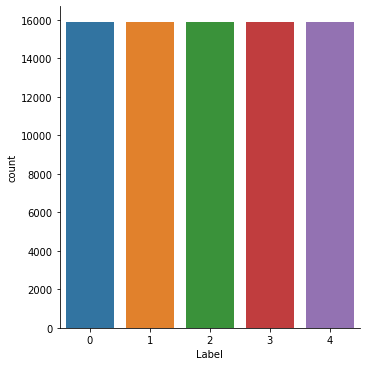

In [35]:
sns.catplot(kind="count", x="Label", data=pd.DataFrame(train_labels_sampled))

In [36]:
train_labels.shape

(37546,)

## Step 2 – Develop a Sentiment Analysis Model

### Building the Model

In [42]:
build_model(
    input_shape=vectorize_params["vector_shape"], n_classes=len(emoji_dictionary)
).summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 300)]         0         
_________________________________________________________________
lstm (LSTM)                  (None, 32, 64)            93440     
_________________________________________________________________
layer_normalization (LayerNo (None, 32, 64)            128       
_________________________________________________________________
lstm_1 (LSTM)                (None, 32, 64)            33024     
_________________________________________________________________
layer_normalization_1 (Layer (None, 32, 64)            128       
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
layer_normalization_2 (Layer (None, 64)                128   

Putting the building blocks together to build a model:

### Train the Model

In [ ]:
lstm_model = train_eval_model(
    train_inputs=train_text_vecs,
    train_labels=train_labels_one_hot,
    test_inputs=test_text_vecs,
    test_labels=test_labels_one_hot,
    build_model_fn=build_model,
    n_classes=len(emoji_dictionary),
    tags={
        "project": "dl-assign-2",
        "part": "1",
        "model": "sentiment",
    },
    input_shape=vectorize_params["vector_shape"],
    git_repo=Repo(search_parent_directories=True),
    run_name=None,
    epochs=60,
    validation_split=0.1,
    lr=1e-3,
    optimizer="adam",
    sgd_momentum=0.9,
    loss="categorical_crossentropy",
    metrics=[
        "accuracy",
    ],
    reduce_lr_stuck=False,
    reduce_lr_patience=10,
    reduce_lr_factor=0.5,
    batch_size=256,
    dropout_prob=0.3,
    l2_reg=None,
    rnn_cell="lstm",
    n_rnn_units=128,
    n_rnn_layers=2,
    rnn_activation="tanh",
    use_layer_norm=True,
    n_dense_units=0,
    use_batch_norm=True,
    dense_activation="relu",
)
mlflow.end_run()

## Step 3 – Evaluate the Model using Testing Data 

TODO: Error analysis on dataset

In [89]:
# Model #1 (replicate where necessary for other models)
# model.load_weights('text_model_1.h5')

In [ ]:
# Save the Best Model
# model.save('text_model_best.h5')

## Step 4 – Use the Best Model to make prediction

In [ ]:
# model.load_weights('text_model_best.h5')

In [ ]:
# takes the user input
# text_input = np.array([input()])

In [ ]:
# convert the user input into numeric tensor

In [ ]:
# show the model output using predict function

# References
- [1] Failure of Classification Accuracy for Imbalanced Class Distributions. (2021, January 21). Retrieved from https://machinelearningmastery.com/failure-of-accuracy-for-imbalanced-class-distributions  
- [2] sudalairajkumar. (2019). Getting started with Text Preprocessing. Kaggle. Retrieved from https://www.kaggle.com/sudalairajkumar/getting-started-with-text-preprocessing
- [3] RaRe-Technologies. (2021, January 28). gensim. Retrieved from https://github.com/RaRe-Technologies/gensim/blob/ba1ce894a5192fc493a865c535202695bb3c0424/docs/notebooks/Word2Vec_FastText_Comparison.ipynb
- [4] Symeonidis, S., Effrosynidis, D., & Arampatzis, A. (2018). A comparative evaluation of pre-processing techniques and their interactions for twitter sentiment analysis. Expert Syst. Appl., 110, 298–310. doi: 10.1016/j.eswa.2018.06.022
- [5] is it possible Apply PCA on any Text Classification? (2021, January 31). Retrieved from https://stackoverflow.com/questions/34725726/is-it-possible-apply-pca-on-any-text-classification
- [6] facebookresearch. (2021, February 01). fastText. Retrieved from https://github.com/facebookresearch/fastText/blob/master/docs/pretrained-vectors.md
- [7] Badr, W. (2020). Having an Imbalanced Dataset? Here Is How You Can Fix It. Towards Data Science. Retrieved from https://towardsdatascience.com/having-an-imbalanced-dataset-here-is-how-you-can-solve-it-1640568947eb